## Main objective of the analysis

The purpose of the analysis is to solve an engineering problem. 
Traditional smoke-detector devices are based on the opacity of the air: when it contains smoke, the light is not allowed through the sensor and then the fire alarm is rung.
These devices use high frequency range radionucleides, with its associated cost.

In this analysis we want to question if an alternative, cheaper device can be built based on metrics related to the chemical contents of the air.
Therefore, and as the purpose is of the engineering type, the purpose is rather predictive than interpretative.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

data = pd.read_csv('smoke_detection_iot.csv')
data.tail()


,Observation,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
62625,62625,1655130047,18.438,15.79,625,400,13723,20569,936.670,0.63,0.65,4.32,0.673,0.015,5739,0
62626,62626,1655130048,18.653,15.87,612,400,13731,20588,936.678,0.61,0.63,4.18,0.652,0.015,5740,0
62627,62627,1655130049,18.867,15.84,627,400,13725,20582,936.687,0.57,0.60,3.95,0.617,0.014,5741,0
62628,62628,1655130050,19.083,16.04,638,400,13712,20566,936.680,0.57,0.59,3.92,0.611,0.014,5742,0
62629,62629,1655130051,19.299,16.52,643,400,13696,20543,936.676,0.57,0.59,3.90,0.607,0.014,5743,0


I will do a first look up of my data.
I can see that all of the data are numeric, i.e. either int or float, in a free range.

In [2]:
data.dtypes

Observation         int64
UTC                 int64
Temperature[C]    float64
Humidity[%]       float64
TVOC[ppb]           int64
eCO2[ppm]           int64
Raw H2              int64
Raw Ethanol         int64
Pressure[hPa]     float64
PM1.0             float64
PM2.5             float64
NC0.5             float64
NC1.0             float64
NC2.5             float64
CNT                 int64
Fire Alarm          int64
dtype: object

Given this result, we can conclude that there are two columns (Observation and time -UTC- which will bring little to the analysis and will add preocessing time, so we will delete them eventually).
Moreover, the dataset is homogeneous in shape: all features are numeric quantities, so no label encoding is needed.

Now I'd like to have a first idea of the correlation between variables. For this I'll use the corr method from pandas and plot it in a color map:

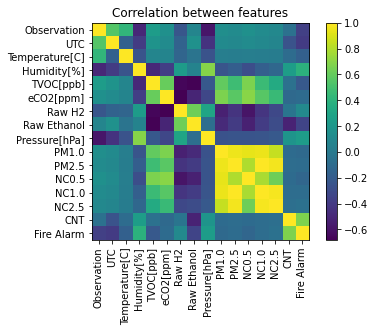

In [3]:
import matplotlib.pyplot as plt,numpy as np
plt.title("Correlation between features")
plt.imshow(data.corr(), interpolation='nearest')

eje = np.arange(len(data.columns.tolist()))
plt.colorbar()
plt.xticks(eje, data.columns,rotation=90)
plt.yticks(eje, data.columns,rotation=0)
plt.show()

In view of the above we can immediately notice that some of the features (PM1.0, PM2.5, etc) are correlated with one another, which may point at potential colinearity among them.

As per the outcome we have selected, correlations seem to be rather and mixed in general as there is no single feature capable of accounting, alone, for the existence of fire. We will see if this yields any result in the next points.

I am going to make sure that Fire Alarm is of type boolean, that is it contains only two values representing True or False.
Indeed, the Fire alarm seems to be boolean, but there is a clear predominance of 1's, so a stratified shuffle split may be interesting here.

In [4]:
data['Fire Alarm'].value_counts(normalize=True)

1    0.714626
0    0.285374
Name: Fire Alarm, dtype: float64

I will be dropping the first column (observation number) which is useless. 
Also pick up the Fire Alarm as the outcome (ground truth), whereas the rest of the columns will be features.

In [5]:
#Dropping the observation column, selecting outcomes and features.
data.drop(columns=['Observation', 'UTC'], inplace=True)
outcome = data['Fire Alarm']
featuresColumns = [x for x in data.columns if x!="Fire Alarm"]
features = pd.DataFrame(data[featuresColumns])

features.head()

,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT
0,20.000,57.36,0,400,12306,18520,939.735,0.0,0.0,0.0,0.0,0.0,0
1,20.015,56.67,0,400,12345,18651,939.744,0.0,0.0,0.0,0.0,0.0,1
2,20.029,55.96,0,400,12374,18764,939.738,0.0,0.0,0.0,0.0,0.0,2
3,20.044,55.28,0,400,12390,18849,939.736,0.0,0.0,0.0,0.0,0.0,3
4,20.059,54.69,0,400,12403,18921,939.744,0.0,0.0,0.0,0.0,0.0,4


In view of the above, we need to make a stratified test split so that we can weigh in the different classes proportionately. The output shows that, in effect, the samples are proportionate.

In [6]:
from msilib.schema import FeatureComponents
from sklearn.model_selection import StratifiedShuffleSplit

myShuffle = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
#StratifiedShuffleSplit()
#a = myShuffle.split(features,outcome)

train_idx, test_idx = next(myShuffle.split(features, outcome))

X_train = features.loc[train_idx, featuresColumns]
y_train = outcome.loc[train_idx]

X_test = features.loc[test_idx, featuresColumns]
y_test = outcome.loc[test_idx]

print(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True), outcome.value_counts(normalize=True))

1    0.714628
0    0.285372
Name: Fire Alarm, dtype: float64 1    0.71462
0    0.28538
Name: Fire Alarm, dtype: float64 1    0.714626
0    0.285374
Name: Fire Alarm, dtype: float64


## Training of three different classifier models

I will be using the following three classifier models:
- Logistic regression
- Decision trees
- Ensemble model based on Random Forest 

For all three models, first we will make this function in order to be able to produce the performance metrics of each model.

In [7]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def measure_error(y_true, y_pred, label):
    return pd.Series({'accuracy':accuracy_score(y_true, y_pred),
                      'precision': precision_score(y_true, y_pred),
                      'recall': recall_score(y_true, y_pred),
                      'f1': f1_score(y_true, y_pred)},
                      name=label)

### LOGISTIC REGRESSION

In [8]:
from sklearn.linear_model import LogisticRegression


lr = LogisticRegression(solver='liblinear')
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

lr_Metrics = measure_error(y_test,y_pred_lr, 'Logistic regression')
lr_Metrics


accuracy     0.989036
precision    0.998492
recall       0.986147
f1           0.992281
Name: Logistic regression, dtype: float64

I made the attempt of checking the confusion matrix and plotting it, however, as there are only 2 classes it doesn't provide a lot of information. I will be using the metrics (recall, precision) instead.

([<matplotlib.axis.YTick at 0x290cefbe5e0>,
 [Text(0, 0, '0'), Text(0, 1, '1')])

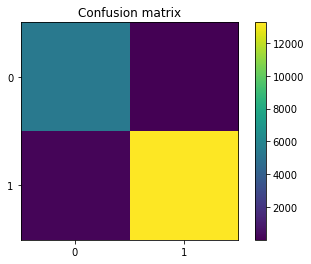

In [9]:
cm = confusion_matrix(y_test, y_pred_lr)

plt.title("Confusion matrix")
plt.imshow(cm, interpolation='nearest')

eje = [0,1]
plt.colorbar()
plt.xticks(eje, eje)
plt.yticks(eje, eje)

## Decision tree

The procedure is exactly the same as with Logistic regression, but with the right class:

In [10]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt = dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

dt_Metrics = measure_error(y_test, y_pred_dt, 'Decision Trees')
dt_Metrics


accuracy     0.999894
precision    0.999851
recall       1.000000
f1           0.999926
Name: Decision Trees, dtype: float64

## Random forest

In this case we need to make a first pre analysis to see what an appropriate number of estimators could be.

In [11]:
from sklearn.ensemble import RandomForestClassifier


RF = RandomForestClassifier(oob_score=True, 
                            random_state=42, 
                            warm_start=True,
                            n_jobs=-1)

oob_list = list()

for n_trees in [15, 20, 30, 40, 50, 100, 150, 200, 300, 400]:
    
    RF.set_params(n_estimators=n_trees)
    RF.fit(X_train, y_train)
    oob_error = 1 - RF.oob_score_    
    oob_list.append(pd.Series({'n_trees': n_trees, 'oob': oob_error}))

rf_oob_df = pd.concat(oob_list, axis=1).T.set_index('n_trees')

rf_oob_df

c:\Users\Usuario\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Usuario\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:550: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\Usuario\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Usuario\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:550: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\Usuario\AppData\Local\Programs\Python\Python39\lib\site-pac

,oob
n_trees,
15.0,0.000798
20.0,0.000137
30.0,0.000114
40.0,0.000068
50.0,0.000068
100.0,0.000068
150.0,0.000068
200.0,0.000068
300.0,0.000068


Here we can see that the model converges to a lower error very, very fast. In principle 40 estimators should serve the purpose.
However if I put only 5 estimators, here is what happens

In [12]:
RFObject_final = RandomForestClassifier(oob_score=True, 
                            random_state=42, 
                            warm_start=True,
                            n_jobs=-1)



rf_final = RFObject_final.set_params(n_estimators=5)

rf_final.fit(X_train, y_train)
y_pred_RF = rf_final.predict(X_test)


rf_metrics = measure_error(y_test, y_pred_RF, 'Random Forest')
rf_metrics

c:\Users\Usuario\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Usuario\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:550: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


accuracy     1.0
precision    1.0
recall       1.0
f1           1.0
Name: Random Forest, dtype: float64

Surprisingly, we achieve a perfect classification with just 5 estimators.
Just to make sure that this is not an eror, I am repeating the experiment with just 2 estimators and this was the result:

| Accuracy   |      Precision      |  Recall | F1|
|------------|:-------------------:|---------|---|
|  0.999521  |  0.999925           | 0.999404|0.999665|


Now it's time to plot the series for our metrics.

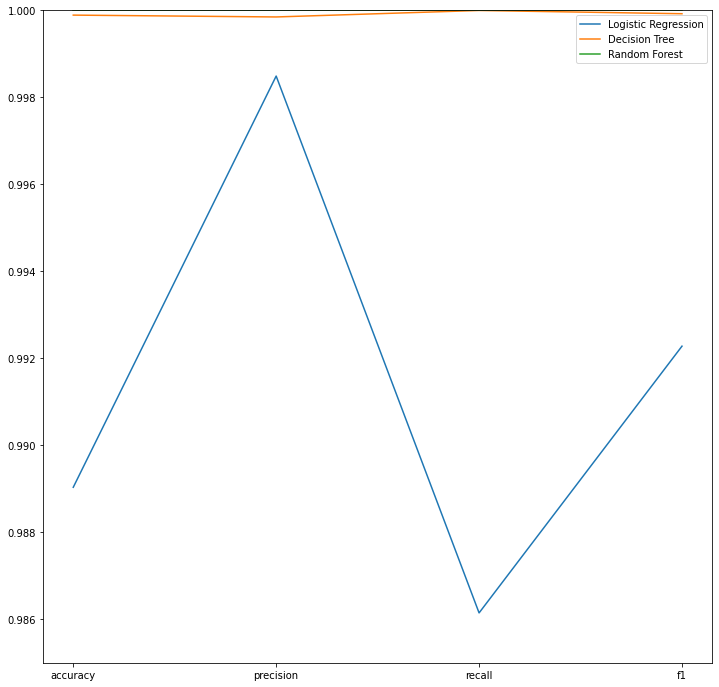

In [13]:
myFigure = plt.figure(figsize=(12, 12))

plt.plot(lr_Metrics, label="Logistic Regression")
plt.plot(dt_Metrics, label="Decision Tree")
plt.plot(rf_metrics, label="Random Forest")
ax = plt.axis(ymin=0.985, ymax=1)
plt.legend()

##### Which of your classifier models would you recommend as a final model that best fits your needs in terms of accuracy and explainability?

Overall, the reliability of all 3 models was very high. Note that, in the chart above, the base scale is .985, which is already very high.

However, based on the experiments, the Random Forest was the one that provided the best results in quality as, we have achieved a perfect classifier (no false positives or negatives).


Considering that the objective is setting the base to build a critical security device, I believe the reliability is important, especially if it's achievable at a reasonable efficiency (as only 5 decision trees where needed).


##### Summary Key Findings and Insight
The key finding is that the characterization of the fire can be done with high degree of confidence.
Therefore the next question would be whether that the profit of building device with sensors for all features can outweigh that of traditional fire sensors.

Also, in a more personal level, I found out that once we have made our split, the models are quite exchangeable, which allows for an easier utilization in ensemble methods.


##### Suggestions for next steps in analyzing this data

Taking into account the original objective of this analysis, the next step would be to ensure a compromise between the data scientist and the manufacturing team.

We have made a good model, but at the cost of installing up to 14 sensors in the device. After all, it's hardly imaginable that a device based on 14 sensors may be competitive against the well-known current devices.

In order to do this, however, we will need to have an interpretative analysis. This I had discarded this approach because the more urgent, mandatory question was whether a classification is achievable. 
After confirming that it is, it would be time to see the real role that each of these 14 features play in the prediction of fire (for which a transformation and other steps would be needed).

I would engage in conversations with the team in charge of manufacturing the device to know more about the manufacturing contraints. For example:
- Which sensors devices that can be built at a reasonably low cost
- Which can still be built but at a higher cost,
- Which cannot be built, 

And then feedback those constraints to my model to see if we can achieve a compromise between data science and manufacturing.